<a href="https://colab.research.google.com/github/RACHAMADUGUSIVASANKAR/Quantum-Portfolio-Optimization/blob/main/Quantum_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing required packages... This may take 2-3 minutes.


✓ Installation complete!

✓ Using qiskit_aer.primitives.Sampler

QUANTUM PORTFOLIO OPTIMIZATION

Configuration:
   Stocks: AAPL, MSFT, GOOGL, AMZN
   Period: 2022-01-01 to 2023-01-01
   Assets to select: 2
   Risk aversion: 0.5

✓ Data downloaded successfully!

Stock Statistics (Annualized):
--------------------------------------------------
  AAPL  : Return=-27.05%  |  Volatility=35.67%
  MSFT  : Return=-58.69%  |  Volatility=50.12%
  GOOGL : Return=-42.55%  |  Volatility=38.73%
  AMZN  : Return=-26.42%  |  Volatility=35.38%
--------------------------------------------------

Formulating quantum optimization problem...
✓ Problem formulated and converted to QUBO

Running QAOA (Quantum Algorithm)...
   Using 3 QAOA repetitions...
Optimization error: Invalid circuits, expected Sequence[QuantumCircuit].

Trying simplified QAOA...
Using classical NumPy solver as fallback...
✓ Optimization complete (using classical fallback)!


OP

/tmp/ipython-input-699140965.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


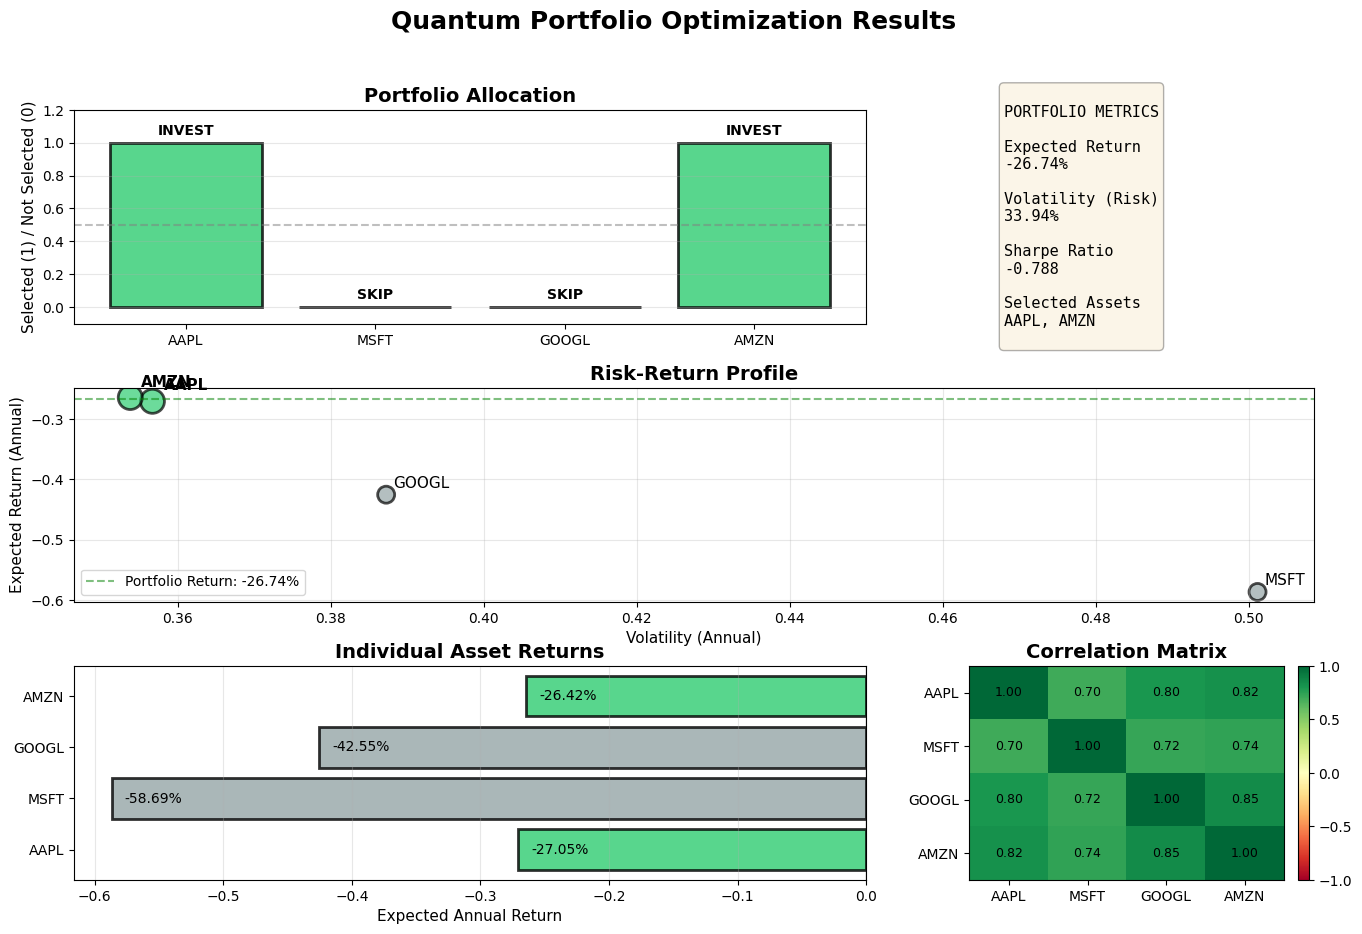

In [ ]:
# STEP 1: Install Required Packages
# ========================================
print("Installing required packages... This may take 2-3 minutes.\n")

!pip install -q qiskit qiskit-aer qiskit-algorithms qiskit-optimization yfinance

print("\n✓ Installation complete!\n")

# STEP 2: Import Libraries
# ========================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from qiskit_aer import Aer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer

USE_LEGACY = False
try:
    from qiskit.primitives import Sampler
    print("✓ Using qiskit.primitives.Sampler")
except ImportError:
    try:
        from qiskit_aer.primitives import Sampler
        print("✓ Using qiskit_aer.primitives.Sampler")
    except ImportError:
        print("✓ Will use compatible QAOA configuration")
        USE_LEGACY = True

print("\n" + "="*70)
print("QUANTUM PORTFOLIO OPTIMIZATION")
print("="*70 + "\n")

# STEP 3: Configuration (Modify These!)
# ========================================
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
start_date = '2022-01-01'
end_date = '2023-01-01'
budget = 2
lambda_risk = 0.5
qaoa_reps = 3

print(f"Configuration:")
print(f"   Stocks: {', '.join(stocks)}")
print(f"   Period: {start_date} to {end_date}")
print(f"   Assets to select: {budget}")
print(f"   Risk aversion: {lambda_risk}\n")

# STEP 4: Download Stock Data
# ========================================
print("Downloading stock data...")
try:
    raw_data = yf.download(stocks, start=start_date, end=end_date, progress=False, auto_adjust=True)

    if len(stocks) == 1:
        data = raw_data['Close'].to_frame()
        data.columns = stocks
    else:
        if isinstance(raw_data.columns, pd.MultiIndex):
            data = raw_data['Close']
        else:
            data = raw_data[['Close']]
            data.columns = stocks

    returns = data.pct_change().dropna()


    mu = returns.mean().values * 252
    cov_matrix = returns.cov().values * 252

    print("✓ Data downloaded successfully!\n")
    print("Stock Statistics (Annualized):")
    print("-" * 50)
    for i, stock in enumerate(stocks):
        print(f"  {stock:6s}: Return={mu[i]:>7.2%}  |  Volatility={np.sqrt(cov_matrix[i,i]):>6.2%}")
    print("-" * 50 + "\n")

except Exception as e:
    print(f"Error downloading data: {e}")
    print("   Check your internet connection and stock symbols.")
    raise


# STEP 5: Formulate Optimization Problem
# ========================================
print("Formulating quantum optimization problem...")
n = len(stocks)
qp = QuadraticProgram(name="portfolio_optimization")

for i in range(n):
    qp.binary_var(name=f'x{i}')

linear = {f'x{i}': -mu[i] for i in range(n)}
quadratic = {(f'x{i}', f'x{j}'): lambda_risk * cov_matrix[i,j]
             for i in range(n) for j in range(n)}
qp.minimize(linear=linear, quadratic=quadratic)

qp.linear_constraint(linear={f'x{i}': 1 for i in range(n)}, sense='==', rhs=budget)

qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(qp)
print("✓ Problem formulated and converted to QUBO\n")


# STEP 6: Solve with QAOA
# ========================================
print("Running QAOA (Quantum Algorithm)...")
print(f"   Using {qaoa_reps} QAOA repetitions...")

try:
    from qiskit_aer.primitives import Sampler as AerSampler
    backend = Aer.get_backend('aer_simulator')
    sampler = AerSampler(backend_options={"method": "automatic"})

    qaoa = QAOA(sampler=sampler, optimizer=COBYLA(), reps=qaoa_reps)
    optimizer = MinimumEigenOptimizer(qaoa)
    result = optimizer.solve(qubo)
    print("✓ Quantum optimization complete!\n")

except Exception as e:
    print(f"Optimization error: {e}")
    print(f"\nTrying simplified QAOA...")

    try:
        from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
        print("Using classical NumPy solver as fallback...")
        solver = NumPyMinimumEigensolver()
        optimizer = MinimumEigenOptimizer(solver)
        result = optimizer.solve(qubo)
        print("✓ Optimization complete (using classical fallback)!\n")
    except Exception as e2:
        print(f"All methods failed: {e2}")
        raise

# STEP 7: Display Results
# ========================================
print("\n" + "="*70)
print("OPTIMAL PORTFOLIO")
print("="*70)

selected_stocks = []
for i, val in enumerate(result.x):
    status = "✅ INVEST" if val > 0 else "⬜ Skip"
    print(f"  {stocks[i]:6s}: {status}")
    if val > 0:
        selected_stocks.append(stocks[i])

expected_return = sum(mu[i] * result.x[i] for i in range(n)) / budget
portfolio_variance = np.dot(result.x, np.dot(cov_matrix, result.x)) / (budget**2)
portfolio_volatility = np.sqrt(portfolio_variance)
sharpe_ratio = expected_return / portfolio_volatility if portfolio_volatility > 0 else 0

print("\n" + "="*70)
print("PORTFOLIO METRICS")
print("="*70)
print(f"  Selected Assets:      {', '.join(selected_stocks)}")
print(f"  Expected Return:      {expected_return:>6.2%} per year")
print(f"  Portfolio Volatility: {portfolio_volatility:>6.2%} per year")
print(f"  Sharpe Ratio:         {sharpe_ratio:>6.3f}")
print(f"  Objective Value:      {result.fval:>6.4f}")
print("="*70 + "\n")

# ========================================
# STEP 8: Visualizations
# ========================================
print("Generating visualizations...\n")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Main title
fig.suptitle('Quantum Portfolio Optimization Results',
             fontsize=18, fontweight='bold', y=0.98)

ax1 = fig.add_subplot(gs[0, :2])
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in result.x]
bars = ax1.bar(stocks, result.x, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_title("Portfolio Allocation", fontweight='bold', fontsize=14)
ax1.set_ylabel("Selected (1) / Not Selected (0)", fontsize=11)
ax1.set_ylim(-0.1, 1.2)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, result.x)):
    label = "INVEST" if val > 0 else "SKIP"
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             label, ha='center', fontweight='bold', fontsize=10)

ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
metrics_text = f"""
PORTFOLIO METRICS

Expected Return
{expected_return:.2%}

Volatility (Risk)
{portfolio_volatility:.2%}

Sharpe Ratio
{sharpe_ratio:.3f}

Selected Assets
{', '.join(selected_stocks)}
"""
ax2.text(0.1, 0.5, metrics_text, fontsize=11, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

ax3 = fig.add_subplot(gs[1, :])
volatilities = [np.sqrt(cov_matrix[i,i]) for i in range(n)]
colors_scatter = ['#2ecc71' if result.x[i] > 0 else '#95a5a6' for i in range(n)]
sizes = [300 if result.x[i] > 0 else 150 for i in range(n)]
scatter = ax3.scatter(volatilities, mu, c=colors_scatter, s=sizes,
                     alpha=0.7, edgecolors='black', linewidth=2)
for i, stock in enumerate(stocks):
    offset = (8, 8) if result.x[i] > 0 else (5, 5)
    weight = 'bold' if result.x[i] > 0 else 'normal'
    ax3.annotate(stock, (volatilities[i], mu[i]),
                xytext=offset, textcoords='offset points',
                fontsize=11, fontweight=weight)
ax3.set_xlabel("Volatility (Annual)", fontsize=11)
ax3.set_ylabel("Expected Return (Annual)", fontsize=11)
ax3.set_title("Risk-Return Profile", fontweight='bold', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=expected_return, color='green', linestyle='--',
           alpha=0.5, label=f'Portfolio Return: {expected_return:.2%}')
ax3.legend()

ax4 = fig.add_subplot(gs[2, :2])
colors_returns = ['#2ecc71' if result.x[i] > 0 else '#95a5a6' for i in range(n)]
bars = ax4.barh(stocks, mu, color=colors_returns, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_xlabel("Expected Annual Return", fontsize=11)
ax4.set_title("Individual Asset Returns", fontweight='bold', fontsize=14)
ax4.axvline(x=0, color='black', linewidth=0.8)
ax4.grid(axis='x', alpha=0.3)
for i, (bar, return_val) in enumerate(zip(bars, mu)):
    ax4.text(return_val + 0.01, bar.get_y() + bar.get_height()/2,
             f'{return_val:.2%}', va='center', fontsize=10)

ax5 = fig.add_subplot(gs[2, 2])
corr_matrix = returns.corr()
im = ax5.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax5.set_xticks(range(n))
ax5.set_yticks(range(n))
ax5.set_xticklabels(stocks, fontsize=10)
ax5.set_yticklabels(stocks, fontsize=10)
ax5.set_title("Correlation Matrix", fontweight='bold', fontsize=14)
plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)

for i in range(n):
    for j in range(n):
        text = ax5.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()
